In [1]:
import torch
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

SystemError: GPU device not found

In [4]:
STYLE_TRANSFORM_PATH = "udnie_aggressive.pth"
PRESERVE_COLOR = True

In [6]:
# TRANSFORMER.PY

class TransformerNetwork(nn.Module):
    """Feedforward Transformation Network without Tanh
    reference: https://arxiv.org/abs/1603.08155 
    exact architecture: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    """
    def __init__(self):
        super(TransformerNetwork, self).__init__()
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU()
        )
        self.ResidualBlock = nn.Sequential(
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3)
        )
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm="None")
        )

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        out = self.DeconvBlock(x)
        return out

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm="instance"):
        super(ConvLayer, self).__init__()
        # Padding Layers
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        # Convolution Layer
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualLayer(nn.Module):
    """
    Deep Residual Learning for Image Recognition

    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, channels=128, kernel_size=3):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride=1)

    def forward(self, x):
        identity = x                     # preserve residual
        out = self.relu(self.conv1(x))   # 1st conv layer + activation
        out = self.conv2(out)            # 2nd conv layer
        out = out + identity             # add residual
        return out

class DeconvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm="instance"):
        super(DeconvLayer, self).__init__()

        # Transposed Convolution 
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

In [7]:
# UTILS.PY

# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

def saveimg(img, image_path):
    img = img.clip(0, 255)
    cv2.imwrite(image_path, img)

# Preprocessing ~ Image to Tensor
def itot(img, max_size=None):
    # Rescale the image
    if (max_size==None):
        itot_t = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])    
    else:
        H, W, C = img.shape
        image_size = tuple([int((float(max_size) / max([H,W]))*x) for x in [H, W]])
        itot_t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])

    # Convert image to tensor
    tensor = itot_t(img)

    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

# Preprocessing ~ Tensor to Image
def ttoi(tensor):
    # Add the means
    #ttoi_t = transforms.Compose([
    #    transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    #img = ttoi_t(tensor)
    img = tensor.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

def transfer_color(src, dest):
    """
    Transfer Color using YIQ colorspace. Useful in preserving colors in style transfer.
    This method assumes inputs of shape [Height, Width, Channel] in BGR Color Space
    """
    src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR).clip(0,255)  #4 Convert new image from YIQ back to BGR

In [10]:
def stylize():
    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Load Transformer Network
    net = TransformerNetwork()
    net.load_state_dict(torch.load(STYLE_TRANSFORM_PATH, map_location=torch.device('cpu')))
    net = net.to(device)

    with torch.no_grad():
        while(1):
            torch.cuda.empty_cache()
            print("Stylize Image~ Press Ctrl+C and Enter to close the program")
            content_image_path = input("Enter the image path: ")
            content_image = load_image(content_image_path)
            starttime = time.time()
            content_tensor = itot(content_image).to(device)
            generated_tensor = net(content_tensor)
            generated_image = ttoi(generated_tensor.detach())
            if (PRESERVE_COLOR):
                generated_image = transfer_color(content_image, generated_image)
            print("Transfer Time: {}".format(time.time() - starttime))
            show(generated_image)
            saveimg(generated_image, "helloworld.jpg")

Stylize Image~ Press Ctrl+C and Enter to close the program
Transfer Time: 1.0961687564849854


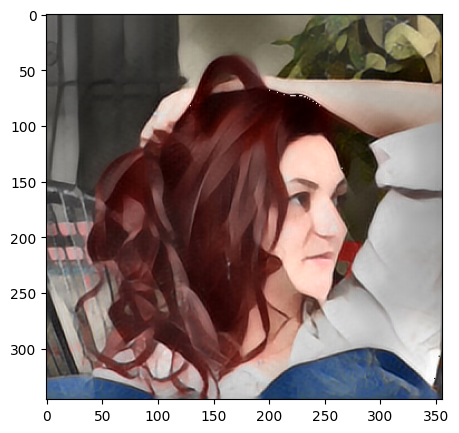

Stylize Image~ Press Ctrl+C and Enter to close the program


KeyboardInterrupt: Interrupted by user

In [11]:
stylize()